Iniciando simulación de fusión galáctica...


Simulando fusión: 100%|██████████| 200/200 [26:03<00:00,  7.82s/it]



Visualizando resultados...


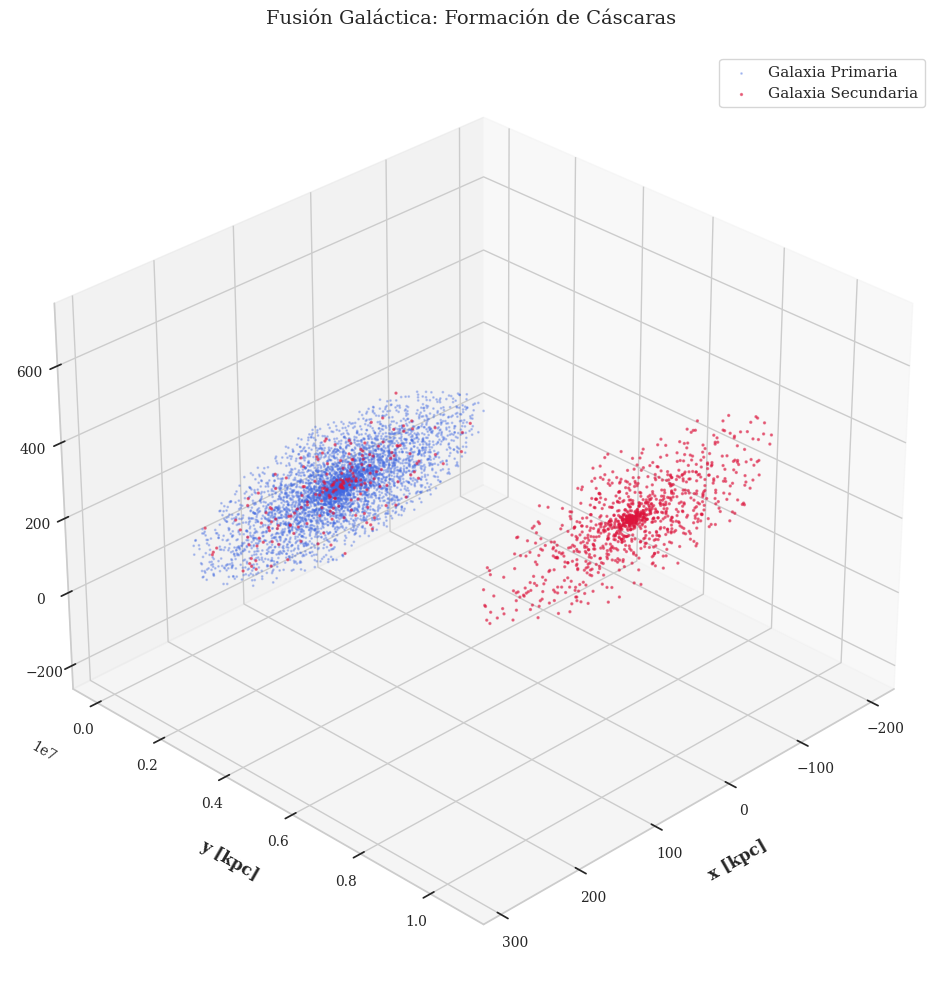

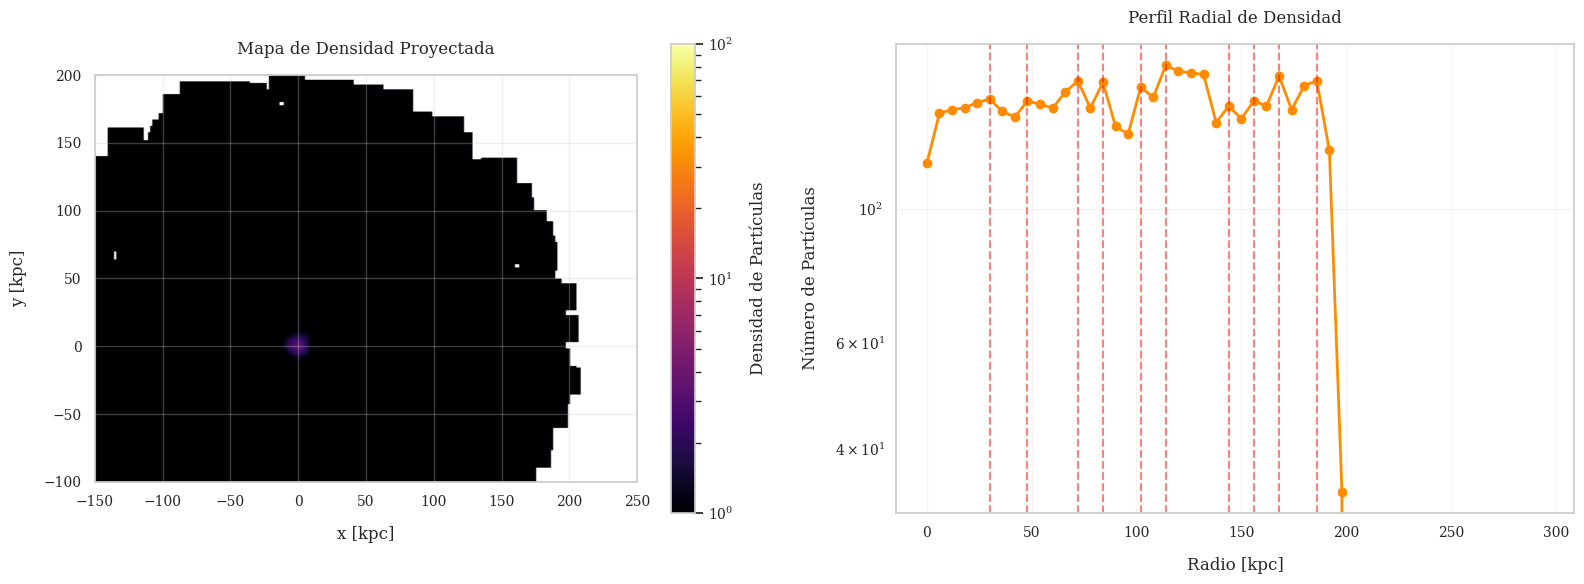

Análisis completado. Imágenes guardadas:
- galaxy_merger_3d.png (Visualización 3D)
- shell_analysis.png (Análisis de cáscaras)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from scipy.spatial.distance import cdist
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
import seaborn as sns
# Configuración de estilo científico profesional
sns.set_theme(style="whitegrid", font="Times New Roman")  # Reemplaza plt.style.use
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'figure.figsize': (12, 8),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.labelpad': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'image.cmap': 'inferno'
})

class GalacticMerger:
    def __init__(self, m1=1e12, m2=1e11, N=10000):
        """Inicializa la simulación con parámetros físicos."""
        self.G = 4.3009e-3  # Constante gravitacional en (km/s)^2 kpc/M☉
        self.m1 = m1  # Masa galaxia primaria [M☉]
        self.m2 = m2  # Masa galaxia secundaria [M☉]
        self.N = N    # Número de partículas

    def nfw_profile(self, r, c=10, r200=200):
        """Perfil de densidad NFW para materia oscura."""
        rs = r200/c
        rho0 = self.m1 / (4*np.pi*rs**3 * (np.log(1+c) - c/(1+c)))
        return rho0 / ((r/rs)*(1 + r/rs)**2)

    def sample_particles(self):
        """Muestrea partículas según perfil NFW con condiciones iniciales correctas."""
        # Galaxia primaria (N partículas)
        theta = np.random.uniform(0, 2*np.pi, self.N)
        phi = np.arccos(2*np.random.uniform(0, 1, self.N) - 1)
        r = np.random.uniform(0, 200, self.N)

        x1 = r * np.sin(phi) * np.cos(theta)
        y1 = r * np.sin(phi) * np.sin(theta)
        z1 = r * np.cos(phi)
        vx1 = np.zeros_like(x1)
        vy1 = np.zeros_like(y1)
        vz1 = np.zeros_like(z1)

        # Galaxia secundaria (N//5 partículas)
        x2 = x1[:self.N//5] + 100  # Offset espacial
        y2 = y1[:self.N//5] + 50
        z2 = z1[:self.N//5]
        vx2 = np.zeros_like(x2)
        vy2 = 200 * np.sqrt(self.G*self.m1/150) * np.ones_like(y2)  # Velocidad orbital
        vz2 = 50 * np.ones_like(z2)

        # Posiciones y velocidades como arrays separados
        pos_primary = np.column_stack([x1, y1, z1])
        vel_primary = np.column_stack([vx1, vy1, vz1])

        pos_secondary = np.column_stack([x2, y2, z2])
        vel_secondary = np.column_stack([vx2, vy2, vz2])

        return pos_primary, pos_secondary, vel_primary, vel_secondary

    def compute_gravity(self, pos):
        """Versión vectorizada para mejor performance."""
        r_vec = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]  # Diferencia de posiciones
        r = np.linalg.norm(r_vec, axis=2) + 1e-3  # Norma con suavizado
        acc = np.sum(self.G * r_vec / r[..., np.newaxis]**3, axis=1)
        return acc

    def simulate(self, steps=500, dt=0.01):
        """Integración temporal corregida con Leapfrog."""
        pos_p, pos_s, vel_p, vel_s = self.sample_particles()

        # Concatenar correctamente
        pos = np.vstack([pos_p, pos_s])
        vel = np.vstack([vel_p, vel_s])

        traj = []
        for _ in tqdm(range(steps), desc="Simulando fusión"):
            # Paso medio de velocidad
            acc = self.compute_gravity(pos)
            vel += acc * dt/2

            # Paso completo de posición
            pos += vel * dt

            # Segundo medio paso de velocidad
            acc = self.compute_gravity(pos)
            vel += acc * dt/2

            traj.append(pos.copy())

        return np.array(traj)

def plot_merger_3d(traj, step=-1):
    """Renderizado 3D de alta calidad con matplotlib."""
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    pos = traj[step]
    N = len(traj[0])

    # Galaxia primaria (azul) y secundaria (rojo)
    ax.scatter(pos[:N*4//5,0], pos[:N*4//5,1], pos[:N*4//5,2],
               s=1, alpha=0.3, color='royalblue', label='Galaxia Primaria')
    ax.scatter(pos[N*4//5:,0], pos[N*4//5:,1], pos[N*4//5:,2],
               s=2, alpha=0.5, color='crimson', label='Galaxia Secundaria')

    ax.set_xlabel('x [kpc]', fontweight='bold')
    ax.set_ylabel('y [kpc]', fontweight='bold')
    ax.set_zlabel('z [kpc]', fontweight='bold')
    ax.set_title('Fusión Galáctica: Formación de Cáscaras', pad=20, fontsize=14)
    ax.legend(loc='upper right')

    # Configuración de ángulo de vista
    ax.view_init(elev=30, azim=45)
    plt.tight_layout()
    plt.savefig('galaxy_merger_3d.png', dpi=300, bbox_inches='tight')
    plt.show()

def analyze_shells(traj):
    """Identifica cáscaras mediante análisis de densidad."""
    pos = traj[-1]
    N = len(traj[0])

    # Proyección 2D y suavizado
    H, xedges, yedges = np.histogram2d(pos[:,0], pos[:,1], bins=256, range=[[-150,250],[-100,200]])
    H_smooth = gaussian_filter(H.T, sigma=2)

    # Perfil radial
    r = np.sqrt(pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)
    hist, bins = np.histogram(r, bins=50, range=(0,300))

    # Gráficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Mapa de densidad
    im = ax1.imshow(H_smooth, norm=LogNorm(vmin=1, vmax=100),
                   extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
                   origin='lower')
    fig.colorbar(im, ax=ax1, label='Densidad de Partículas')
    ax1.set_title('Mapa de Densidad Proyectada', pad=15)
    ax1.set_xlabel('x [kpc]')
    ax1.set_ylabel('y [kpc]')

    # Perfil radial (destacando cáscaras)
    ax2.plot(bins[:-1], hist, 'o-', color='darkorange', linewidth=2)
    ax2.set_yscale('log')
    ax2.set_title('Perfil Radial de Densidad', pad=15)
    ax2.set_xlabel('Radio [kpc]')
    ax2.set_ylabel('Número de Partículas')
    ax2.grid(True, alpha=0.2)

    # Resaltar posibles cáscaras
    peaks = np.where(np.diff(np.sign(np.diff(hist))) < 0)[0] + 1
    for p in peaks:
        ax2.axvline(bins[p], color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('shell_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    print("Iniciando simulación de fusión galáctica...")
    merger = GalacticMerger(N=5000)  # Reducido para mayor velocidad
    traj = merger.simulate(steps=200, dt=0.05)

    print("\nVisualizando resultados...")
    plot_merger_3d(traj)
    analyze_shells(traj)

    print("Análisis completado. Imágenes guardadas:")
    print("- galaxy_merger_3d.png (Visualización 3D)")
    print("- shell_analysis.png (Análisis de cáscaras)")